## Load the data

In [1]:
from dagster import AssetKey
from pudl.etl import defs
import pandas as pd
from pudl.helpers import zero_pad_numeric_string, standardize_phone_column, standardize_na_values
import numpy as np
import re
from pudl.metadata.dfs import POLITICAL_SUBDIVISIONS

In [2]:
raw_df = defs.load_asset_value(AssetKey("raw_phmsagas__yearly_distribution"))

No dagster instance configuration file (dagster.yaml) found at /Users/sam/Documents/pudl-data/dagster_home. Defaulting to loading and storing all metadata with /Users/sam/Documents/pudl-data/dagster_home. If this is the desired behavior, create an empty dagster.yaml file in /Users/sam/Documents/pudl-data/dagster_home.
2024-11-03 16:45:36 -0500 - dagster - DEBUG - system - Loading file from: /Users/sam/Documents/pudl-data/dagster_home/storage/raw_phmsagas__yearly_distribution using PickledObjectFilesystemIOManager...


In [3]:
YEARLY_DISTRIBUTION_OPERATORS_COLUMNS = {
    "columns_to_keep": [
        "report_date",
        "report_number",  # not in pudl/metadata/fields.py
        "report_submission_type",  # not in pudl/metadata/fields.py
        "report_year",
        # None of the columns below are in pudl/metadata/fields.py
        "operator_id_phmsa",
        "operator_name_phmsa",
        "office_address_street",
        "office_address_city",
        "office_address_state",
        "office_address_zip",
        "office_address_county",
        "headquarters_address_street",
        "headquarters_address_city",
        "headquarters_address_state",
        "headquarters_address_zip",
        "headquarters_address_county",
        "excavation_damage_excavation_practices",
        "excavation_damage_locating_practices",
        "excavation_damage_one_call_notification",
        "excavation_damage_other",
        "excavation_damage_total",
        "excavation_tickets",
        "services_efv_in_system",
        "services_efv_installed",
        "services_shutoff_valve_in_system",
        "services_shutoff_valve_installed",
        "federal_land_leaks_repaired_or_scheduled",
        "percent_unaccounted_for_gas",
        "additional_information",
        "preparer_email",
        "preparer_fax",
        "preparer_name",
        "preparer_phone",
        "preparer_title",
    ],
    "columns_to_convert_to_ints": [
        "report_year",
        "report_number",
        "operator_id_phmsa",
        "excavation_damage_excavation_practices",
        "excavation_damage_locating_practices",
        "excavation_damage_one_call_notification",
        "excavation_damage_other",
        "excavation_damage_total",
        "excavation_tickets",
        "services_efv_in_system",
        "services_efv_installed",
        "services_shutoff_valve_in_system",
        "services_shutoff_valve_installed",
    ],
    "capitalization_exclusion": ["headquarters_address_state", "office_address_state"],
}

In [4]:
df = raw_df.loc[
    :, YEARLY_DISTRIBUTION_OPERATORS_COLUMNS["columns_to_keep"]
].copy()

# Standardize NAs
df = standardize_na_values(df)

# Initial string cleaning
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].str.strip()

# Specify the columns to convert to integer type
cols_to_convert = YEARLY_DISTRIBUTION_OPERATORS_COLUMNS[
    "columns_to_convert_to_ints"
]

# Fill NaN values with pd.NA, then cast to "Int64" nullable integer type
df[cols_to_convert] = df[cols_to_convert].fillna(pd.NA).astype("Int64")

# Ensure all "report_year" values have four digits
mask = df["report_year"] < 100

# Convert 2-digit years to appropriate 4-digit format (assume cutoff at year 50)
# We could also use the first 4 digits of the "report_number" but there was at least one anomaly here with an invalid year
df.loc[mask, "report_year"] = 2000 + df.loc[mask, "report_year"].where(
    df.loc[mask, "report_year"] < 50, 1900
)

# Standardize case for city, county, operator name, etc.
# Capitalize the first letter of each word in a list of columns
cap_cols = df.select_dtypes(include=["object"]).columns.difference(
    YEARLY_DISTRIBUTION_OPERATORS_COLUMNS["capitalization_exclusion"]
)
for col in cap_cols:
    df[col] = df[col].str.title()

# Standardize state abbreviations
state_to_abbr = {
    x.subdivision_name: x.subdivision_code
    for x in POLITICAL_SUBDIVISIONS.itertuples()
    if x.country_code == "USA" and x.subdivision_type == "state"
}
state_to_abbr.update(
    {
        x.subdivision_code: x.subdivision_code
        for x in POLITICAL_SUBDIVISIONS.itertuples()
        if x.country_code == "USA" and x.subdivision_type == "state"
    }
)

for state_col in ["headquarters_address_state", "office_address_state"]:
    df[state_col] = (
        df[state_col]
        .str.strip()
        .replace(state_to_abbr)
        .where(df[state_col].isin(state_to_abbr.values()), pd.NA)
    )

# Standardize zip codes
df["office_address_zip"] = zero_pad_numeric_string(
    df["office_address_zip"], n_digits=5
)
df["headquarters_address_zip"] = zero_pad_numeric_string(
    df["headquarters_address_zip"], n_digits=5
)

# Standardize telephone and fax number format and drop (000)-000-0000
df = standardize_phone_column(df, ["preparer_phone", "preparer_fax"])

/Users/sam/Documents/pudl/src/pudl/helpers.py:1033: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(na_patterns, np.nan, regex=True)


In [6]:
df.head()

,report_date,report_number,report_submission_type,report_year,operator_id_phmsa,operator_name_phmsa,office_address_street,office_address_city,office_address_state,office_address_zip,office_address_county,headquarters_address_street,headquarters_address_city,headquarters_address_state,headquarters_address_zip,headquarters_address_county,excavation_damage_excavation_practices,excavation_damage_locating_practices,excavation_damage_one_call_notification,excavation_damage_other,excavation_damage_total,excavation_tickets,services_efv_in_system,services_efv_installed,services_shutoff_valve_in_system,services_shutoff_valve_installed,federal_land_leaks_repaired_or_scheduled,percent_unaccounted_for_gas,additional_information,preparer_email,preparer_fax,preparer_name,preparer_phone,preparer_title
0,NaT,19901506,NaN,1990,18,"Abbyville, City Of",P O Box 100,Abbyville,KS,<NA>,Reno,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,NaN,NaN,NaN,<NA>,Debra Ehling,<NA>,NaN
1,NaT,19900095,NaN,1990,27,Abita Springs Nat Gas & Water,Level Street,Abita Springs,LA,<NA>,St. Tammany,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,4.0,NaN,NaN,<NA>,Barbara Giancontieri,<NA>,NaN
2,NaT,19900947,NaN,1990,45,"Adairsville, City Of",P.O. Box 830,Adairsville,GA,<NA>,Bartow,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,0.0,NaN,NaN,<NA>,Chris Strippelhoff - Consultant,<NA>,NaN
3,NaT,19901193,NaN,1990,49,"Adamsville Gas Dept, Town Of",231 East Main Street,Adamsville,TN,<NA>,Mcnairy,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,3.8,NaN,NaN,<NA>,"E. George Leckner, Jr. - Gas System Analyst",<NA>,NaN
4,NaT,19900948,NaN,1990,54,"Adel Gas Dept, City Of",City Hall - P.O. Box 658,Adel,GA,<NA>,Cook,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,3.5,NaN,NaN,<NA>,Chris Strippelhoff - Consultant,<NA>,NaN


In [7]:
df.percent_unaccounted_for_gas.head()

0    NaN
1    4.0
2    0.0
3    3.8
4    3.5
Name: percent_unaccounted_for_gas, dtype: float64

In [10]:
print(negative_count / (positive_count + negative_count)) 

0.033715048084940795


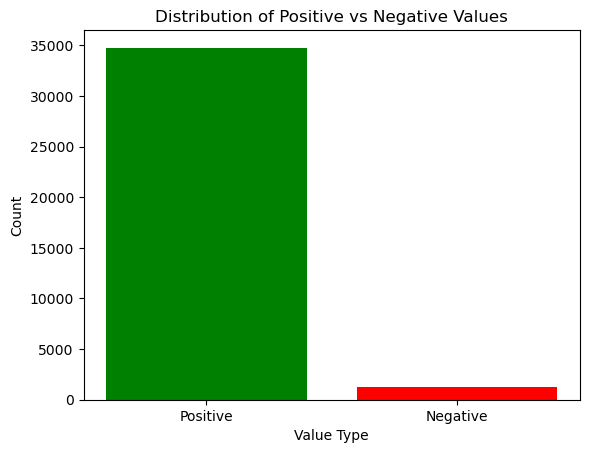

In [9]:
import matplotlib.pyplot as plt

positive_count = (df['percent_unaccounted_for_gas'] > 0).sum()
negative_count = (df['percent_unaccounted_for_gas'] < 0).sum()

# Data for plotting
labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]

# Create the bar plot
plt.bar(labels, counts, color=['green', 'red'])
plt.title('Distribution of Positive vs Negative Values')
plt.xlabel('Value Type')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate labels if necessary
plt.show()


In [13]:
df[df.percent_unaccounted_for_gas<0]

,report_date,report_number,report_submission_type,report_year,operator_id_phmsa,operator_name_phmsa,office_address_street,office_address_city,office_address_state,office_address_zip,office_address_county,headquarters_address_street,headquarters_address_city,headquarters_address_state,headquarters_address_zip,headquarters_address_county,excavation_damage_excavation_practices,excavation_damage_locating_practices,excavation_damage_one_call_notification,excavation_damage_other,excavation_damage_total,excavation_tickets,services_efv_in_system,services_efv_installed,services_shutoff_valve_in_system,services_shutoff_valve_installed,federal_land_leaks_repaired_or_scheduled,percent_unaccounted_for_gas,additional_information,preparer_email,preparer_fax,preparer_name,preparer_phone,preparer_title
1047,NaT,19902721,NaN,1990,15233,"Pfg Gas, Inc",55 S. Third Street,Oxford,PA,<NA>,Chester,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,-0.90,NaN,NaN,<NA>,Robert Beard,<NA>,NaN
2146,NaT,19910719,NaN,1991,7650,Humboldt Utilities - Gas Dept,207 S 13Th Ave. P.O. Box 850,Humboldt,TN,<NA>,Gibson,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,-1.67,NaN,NaN,<NA>,Gregory D Hall,<NA>,NaN
3545,NaT,19920497,NaN,1992,11064,"Lafayette Gas & Utilities Dept, City Of",200 East Locust St.,Lafayette,TN,<NA>,Macon,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,-4.00,NaN,NaN,<NA>,Phillip Brawner - Gas Supt.,<NA>,NaN
3904,NaT,19920894,NaN,1992,14130,Ohio Gas Co,200 West High St,Bryan,OH,<NA>,Williams,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,-0.62,NaN,NaN,<NA>,Anton H Jessberger,<NA>,NaN
4681,NaT,19930082,NaN,1993,828,"Atmore Utilities Board, City Of",201 E. Louisville Avenue,Atmore,AL,<NA>,Escambia,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,-4.00,NaN,NaN,<NA>,Vickie M. James - Clerk Of The Board,<NA>,NaN


In [14]:
df.columns

Index(['report_date', 'report_number', 'report_submission_type', 'report_year', 'operator_id_phmsa', 'operator_name_phmsa', 'office_address_street', 'office_address_city', 'office_address_state', 'office_address_zip', 'office_address_county', 'headquarters_address_street', 'headquarters_address_city', 'headquarters_address_state', 'headquarters_address_zip', 'headquarters_address_county', 'excavation_damage_excavation_practices', 'excavation_damage_locating_practices', 'excavation_damage_one_call_notification', 'excavation_damage_other', 'excavation_damage_total', 'excavation_tickets', 'services_efv_in_system', 'services_efv_installed', 'services_shutoff_valve_in_system', 'services_shutoff_valve_installed', 'federal_land_leaks_repaired_or_scheduled', 'percent_unaccounted_for_gas', 'additional_information', 'preparer_email', 'preparer_fax', 'preparer_name', 'preparer_phone', 'preparer_title'], dtype='object')

## core_phmsagas__yearly_distribution_operators

In [3]:
df = raw_df[[
    "report_date",
    "report_number",
    "report_submission_type",
    "report_year",
    "operator_id_phmsa",
    "operator_name_phmsa",
    "office_address_street",
    "office_address_city",
    "office_address_state",
    "office_address_zip",
    "office_address_county",
    "headquarters_address_street",
    "headquarters_address_city",
    "headquarters_address_state",
    "headquarters_address_zip",
    "headquarters_address_county",
    "excavation_damage_excavation_practices",
    "excavation_damage_locating_practices",
    "excavation_damage_one_call_notification",
    "excavation_damage_other",
    "excavation_damage_total",
    "excavation_tickets",
    "services_efv_in_system",
    "services_efv_installed",
    "services_shutoff_valve_in_system",
    "services_shutoff_valve_installed",
    "federal_land_leaks_repaired_or_scheduled",
    "percent_unaccounted_for_gas",
    "additional_information",
    "preparer_email",
    "preparer_fax",
    "preparer_name",
    "preparer_phone",
    "preparer_title"
]]

In [ ]:
# Convert columns to ints
# Excluded "federal_land_leaks_repaired_or_scheduled" from this list since there were a couple rows with decimal values
columns_to_convert = [
    "report_year",
    "report_number",
    "operator_id_phmsa",
    "excavation_damage_excavation_practices",
    "excavation_damage_locating_practices",
    "excavation_damage_one_call_notification",
    "excavation_damage_other",
    "excavation_damage_total",
    "excavation_tickets",
    "services_efv_in_system",
    "services_efv_installed",
    "services_shutoff_valve_in_system",
    "services_shutoff_valve_installed"
]
df[columns_to_convert] = df[columns_to_convert].astype("Int64")

In [5]:
# Ensure all "report_year" values have four digits
mask = df["report_year"] < 100

# Convert 2-digit years to appropriate 4-digit format (assume cutoff at year 50)
# We could also use the first 4 digits of the "report_number" but there was at least one anomaly here with an invalid year
df.loc[mask, "report_year"] = df.loc[mask, "report_year"].apply(
    lambda x: 2000 + x if x < 50 else 1900 + x
)

### Operator Table Tasks

#### Standardize NAs

In [ ]:
# Fill NA values with zeroes because these columns are simply counts.
# Note that "excavation_damage..." columns should sum up to the value in "excavation_damage_total". However, many rows
# (on the scale of thousands) do not actually sum up to "excavation_damage_total".
columns_to_fill = [
    "excavation_damage_excavation_practices",
    "excavation_damage_locating_practices",
    "excavation_damage_one_call_notification",
    "excavation_damage_other",
    "excavation_damage_total",
    "excavation_tickets",
    "services_efv_in_system",
    "services_efv_installed",
    "services_shutoff_valve_in_system",
    "services_shutoff_valve_installed",
    "federal_land_leaks_repaired_or_scheduled"
]
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# Fill in bad strings
df = standardize_na_values(df)

#### Standardize case for city, county, operator name, etc.

In [7]:
# Capitalize the first letter of each word in all object-type columns except the excluded ones
exclude_columns = ['headquarters_address_state', 'office_address_state']
df[df.select_dtypes(include=['object']).columns.difference(exclude_columns)] = \
    df[df.select_dtypes(include=['object']).columns.difference(exclude_columns)].apply(lambda col: col.str.title())

In [8]:
# Standardize state abbreviations
# First create a dictionary of state names to abbreviations
state_to_abbr = {
    x.subdivision_name: x.subdivision_code
    for x in POLITICAL_SUBDIVISIONS.itertuples()
    if x.country_code == "USA" and x.subdivision_type == "state"
}
# Add abbreviations to the dictionary
state_to_abbr.update({
    x.subdivision_code: x.subdivision_code
    for x in POLITICAL_SUBDIVISIONS.itertuples()
    if x.country_code == "USA" and x.subdivision_type == "state"
})

def standardize_state(state):
    if pd.isna(state):
        return state
    state = state.strip()
    standardized_state = state_to_abbr.get(state, state)
    if standardized_state not in state_to_abbr.values():
        return np.nan
    return standardized_state

In [9]:
df["headquarters_address_state"] = df["headquarters_address_state"].apply(standardize_state)
df["office_address_state"] = df["office_address_state"].apply(standardize_state)

In [ ]:
# Trim all the object-type columns
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).applymap(lambda x: x.strip() if isinstance(x, str) else x)

#### Standardize telephone and fax number format and drop (000)-000-0000


In [11]:
df = standardize_phone_column(df, ["preparer_phone", "preparer_fax"])

### Other cleanup

In [12]:
# Standardize zip codes
df["office_address_zip"] = zero_pad_numeric_string(df["office_address_zip"], n_digits=5)
df["headquarters_address_zip"] = zero_pad_numeric_string(df["headquarters_address_zip"], n_digits=5)

In [14]:
# Strip whitespace from all object (string) columns
df[df.select_dtypes(include=["object"]).columns] = df.select_dtypes(
    include=["object"]
).apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))
